In [1]:
#!pip install emoji
#!pip install spacy
#!pip install sentence_transformers
import pandas as pd
import numpy as np
import emoji
import regex
import nltk
import re
import sklearn
import string
import random
import os
import torch

#import spacy
from collections import Counter
from sentence_transformers import SentenceTransformer

#set seeds
random.seed(10)
np.random.seed(10)
seed = 10

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/sander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('data2021.csv')
print(len(df))
df = df.drop_duplicates(subset=['user_id']) # remove duplicates

392446


In [4]:
df.dropna(subset=['user_description'], inplace=True) # remove NaN values

In [5]:
df['user_description']

1         Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸...
2         IT ICT IoT || •AgriFoodTech •Biobased •Circula...
6         Leesbaar, kroniek van gebeurtenissen in Amsterdam
7         Mijn #TOTELTUIN ++ #Noseflutejob ++ Bach on th...
8         Columnist https://t.co/eX0BHLeWH2. Boosdrietig...
                                ...                        
392401    Je suis un 🤖 veillant sur la qualité de l'air ...
392414    Voor het meest uitgebreide zakelijke nieuws be...
392416    Uitgeverij Historische Verhalen publiceert kor...
392422    Dutch,Jewish,single,had a great friend for lif...
392442     Gitarist (klassiek) 🎸🎼🎵🎶 en 🖥️🗃️🛠️ 😎 IT-Goeroe 😎
Name: user_description, Length: 92363, dtype: object

In [6]:
def give_emoji_free_text(text):
    """
    Description:
        Removes emojis from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (emoji free biographies)
    Example:
        >>> give_emoji_free_text('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        'Wiskunde lover, honden freak.'
    """
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Description:
        Removes URLs from given text (biographies)
    Input:
        Text as string (biographies)
    Output:
        Text as string (URL free biographies)
    Example:
        >>> url_free_text('Columnist https://t.co/eX0BHLeWH2. Boosdrietig')
        'Columnist Boosdrietig'
    '''
    text = re.sub(r'http\S+', '', text)
    return text

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Apply the give_emoji_free_text function and get biographies free of emojis
call_emoji_free = lambda x: give_emoji_free_text(x)

wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(bio):
    '''
    Description:
        Preprocesses input text by: removing: punctuation, emojis, URLs, Dutch and English stopwords, \
        tokenisation, lowercasing and lemmatisation.
    Input:
        Text as string (biographies)
    Output:
        Text as list (preprocessed biographies)
    Example:
        >>> preprocessing('Wiskunde lover, honden freak. 🇮🇱🇹🇭🏁🇩🇪🇭🇺🇳🇱🇷🇸🇸🇽🇸')
        [wiskunde, lover, honden, freak]
    '''
    
    bio = "".join([i for i in bio if i not in (string.punctuation + '•')]) # Remove punctuation
    bio = call_emoji_free(bio) # Remove emojis
    bio = url_free_text(bio).rstrip() # Remove URLs
    bio = word_tokenize(bio, language="dutch") # Tokenise the biography
    
    bio = [item.lower() for item in bio] # lowercase
    
    stopwords = nltk.corpus.stopwords.words('dutch')
    bio = [i for i in bio if i not in stopwords] # Remove Dutch stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    bio = [i for i in bio if i not in stopwords] # Remove English stopwords
    
    bio = [wordnet_lemmatizer.lemmatize(word) for word in bio] # Lemmatise the biographies
    
    return bio
    

In [8]:
df['preprocessed'] = df['user_description'].apply(preprocessing)

# Remove biographies which contain links only
df = df[df.astype(str)['preprocessed'] != '[]']

In [9]:
df['preprocessed']

1                          [wiskunde, lover, honden, freak]
2         [ict, iot, agrifoodtech, biobased, circular, d...
6            [leesbaar, kroniek, gebeurtenissen, amsterdam]
7         [toteltuin, noseflutejob, bach, sheepdogwhistl...
8         [columnist, boosdrietig, vanwege, tweet, jamme...
                                ...                        
392401    [suis, un, veillant, sur, la, qualité, lair, q...
392414    [meest, uitgebreide, zakelijke, nieuws, bezoek...
392416    [uitgeverij, historische, verhalen, publiceert...
392422    [dutchjewishsinglehad, great, friend, life, po...
392442                       [gitarist, klassiek, itgoeroe]
Name: preprocessed, Length: 90898, dtype: object

In [10]:
# Create sentence embeddings using multilingual BERT model
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Our sentences we like to encode
sentences_list =  df['preprocessed'].values
sentences = []
for i in sentences_list:
    detok = " ".join(i)
    sentences.append(detok)
    #sentences.append(" ".join(i)) # Check of deze regel ook werkt, is een stap minder
embeddings = model.encode(sentences)

In [11]:
#!pip install yellowbrick

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

def elbow(min=15,max=25):
    ''' 
    Description:
        Computes a graphical visualisation of the Elbow Method given a min and max value for K
    Args:
        min: Minimal value of K
        max: Maximum value of K
    Output:
        A graphical visualisation of the Elbow Method
    '''
    Sum_of_squared_distances =[]
    K = range(min,max)
    for k in K:
        km =KMeans(n_clusters =k, n_init = 10, random_state=seed) # Initialise the k-means clusterer
        km =km.fit(embeddings) # Compute k-means clustering
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


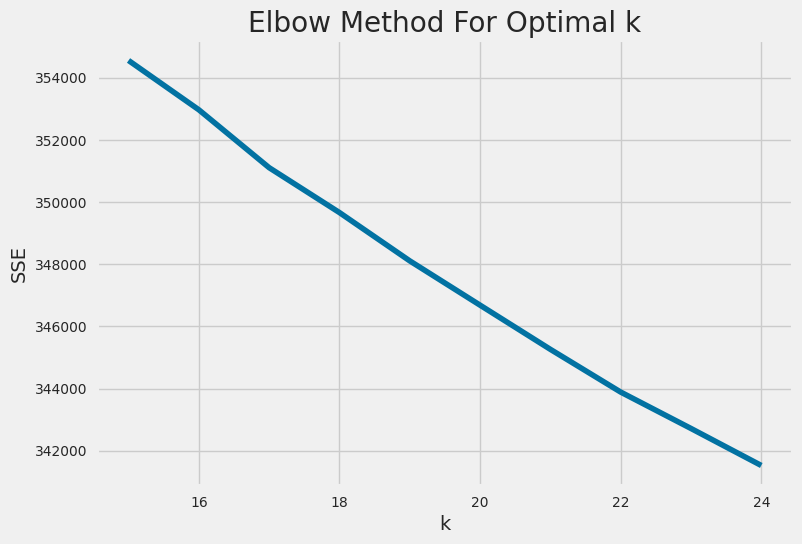

In [13]:
elbow(15,25)

In [14]:
km = KMeans(n_clusters = 23, n_init = 10, random_state=seed) # Initialise the k-means clusterer
km = km.fit(embeddings) # Compute k-means clustering

In [15]:
label = km.predict(embeddings) # Compute cluster centers and predict cluster index for each sample

In [16]:
centers = (km.cluster_centers_)

In [17]:
cluster_dict = {}
freq_dict = {}
for count, value in enumerate(sentences):
    if label[count] in cluster_dict:
        freq_dict[label[count]] += 1
        cluster_dict[label[count]] += value
    else:
        freq_dict[label[count]] = 1
        cluster_dict[label[count]] = value

In [18]:
from collections import Counter
cluster = {}
for i in cluster_dict:
    wordsList = str(cluster_dict[i]).split()
    wordsList = [ x for x in wordsList if x.isalpha() ]
    counters = Counter(wordsList)
    most_occur = counters.most_common(10)
    n_words = []
    for word in most_occur:
        n_words.append(word[0])
        
    print(n_words, "Cluster:", i, "Size:", freq_dict[i])
    cluster[i] = n_words[0]

['natuur', 'dieren', 'animal', 'nature', 'love', 'graag', 'wandelen', 'leven', 'dog', 'katten'] Cluster: 19 Size: 3408
['energie', 'duurzame', 'natuur', 'duurzaamheid', 'energy', 'klimaat', 'duurzaam', 'climate', 'saman', 'groen'] Cluster: 16 Size: 3153
['nederland', 'amsterdam', 'dutch', 'netherlands', 'nederlandse', 'nieuws', 'tweet', 'eu', 'politiek', 'belgië'] Cluster: 12 Size: 3704
['politiek', 'vrijheid', 'anti', 'rechts', 'politieke', 'right', 'link', 'eu', 'freedom', 'pro'] Cluster: 10 Size: 5274
['tweet', 'persoonlijke', 'twitter', 'account', 'twitteraccount', 'eigen', 'twittert', 'titel', 'nieuws', 'volg'] Cluster: 13 Size: 5363
['nieuws', 'uur', 'sind', 'jaar', 'wij', 'rechts', 'den', 'alle', 'onze', 'bel'] Cluster: 20 Size: 6960
['wel', 'som', 'graag', 'dingen', 'gewoon', 'leven', 'mensen', 'dag', 'gek', 'humor'] Cluster: 5 Size: 5514
['mening', 'waarheid', 'mensen', 'wel', 'truth', 'som', 'people', 'wereld', 'eigen', 'kritisch'] Cluster: 18 Size: 4024
['sport', 'fan', 'voe

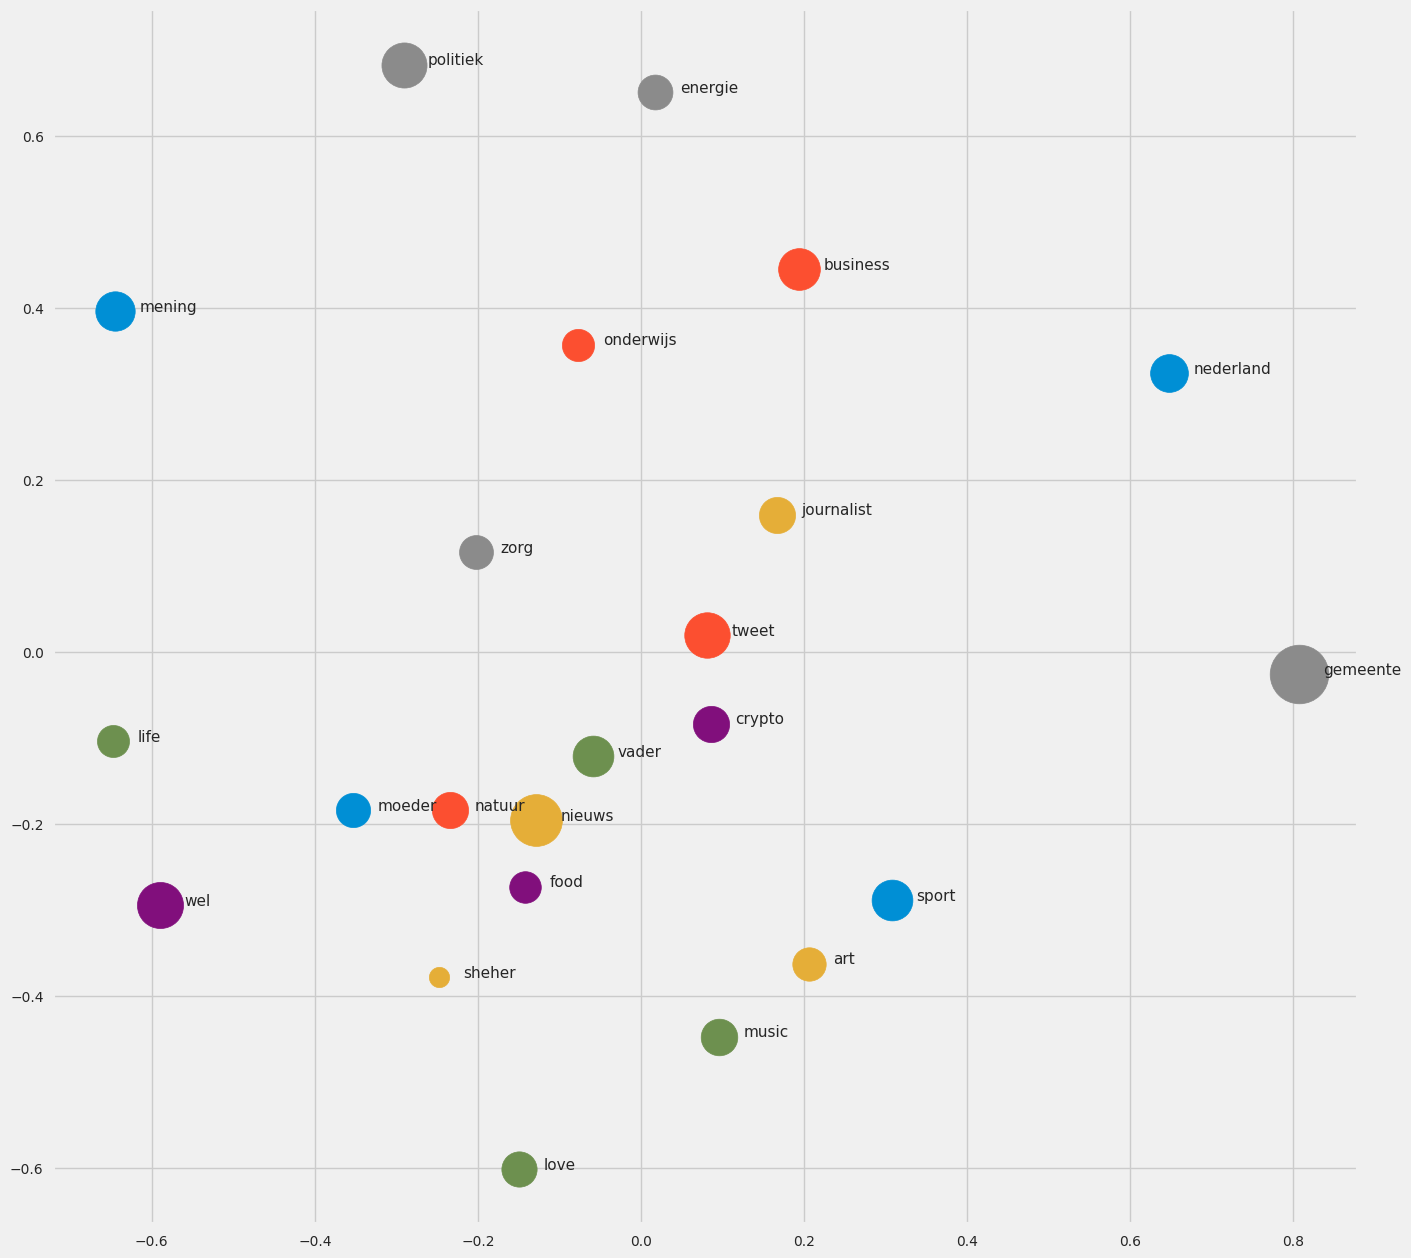

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
H = pca.fit(embeddings)

center_2d = H.transform(centers)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
for i, value in enumerate(center_2d):
    ax.scatter(x = value[0], y = value[1], s = (freq_dict[i]/5))
    ax.annotate(cluster[i], xy= (value[0], value[1]), fontsize = 11, xytext = (value[0] + 0.03, value[1])) 

In [20]:
from collections import Counter
cluster = {}
name_list = []

for i in cluster_dict:
    wordsList = str(cluster_dict[i]).split()
    wordsList = [ x for x in wordsList if x.isalpha() ]
    counters = Counter(wordsList)
    most_occur = counters.most_common(10)
    n_words = []
    for word in most_occur:
        n_words.append(word[0])
        
    name_list.append(n_words[0])
    print(n_words, "Cluster:", i, "Size:", freq_dict[i])
    cluster[i] = n_words[0]

['natuur', 'dieren', 'animal', 'nature', 'love', 'graag', 'wandelen', 'leven', 'dog', 'katten'] Cluster: 19 Size: 3408
['energie', 'duurzame', 'natuur', 'duurzaamheid', 'energy', 'klimaat', 'duurzaam', 'climate', 'saman', 'groen'] Cluster: 16 Size: 3153
['nederland', 'amsterdam', 'dutch', 'netherlands', 'nederlandse', 'nieuws', 'tweet', 'eu', 'politiek', 'belgië'] Cluster: 12 Size: 3704
['politiek', 'vrijheid', 'anti', 'rechts', 'politieke', 'right', 'link', 'eu', 'freedom', 'pro'] Cluster: 10 Size: 5274
['tweet', 'persoonlijke', 'twitter', 'account', 'twitteraccount', 'eigen', 'twittert', 'titel', 'nieuws', 'volg'] Cluster: 13 Size: 5363
['nieuws', 'uur', 'sind', 'jaar', 'wij', 'rechts', 'den', 'alle', 'onze', 'bel'] Cluster: 20 Size: 6960
['wel', 'som', 'graag', 'dingen', 'gewoon', 'leven', 'mensen', 'dag', 'gek', 'humor'] Cluster: 5 Size: 5514
['mening', 'waarheid', 'mensen', 'wel', 'truth', 'som', 'people', 'wereld', 'eigen', 'kritisch'] Cluster: 18 Size: 4024
['sport', 'fan', 'voe

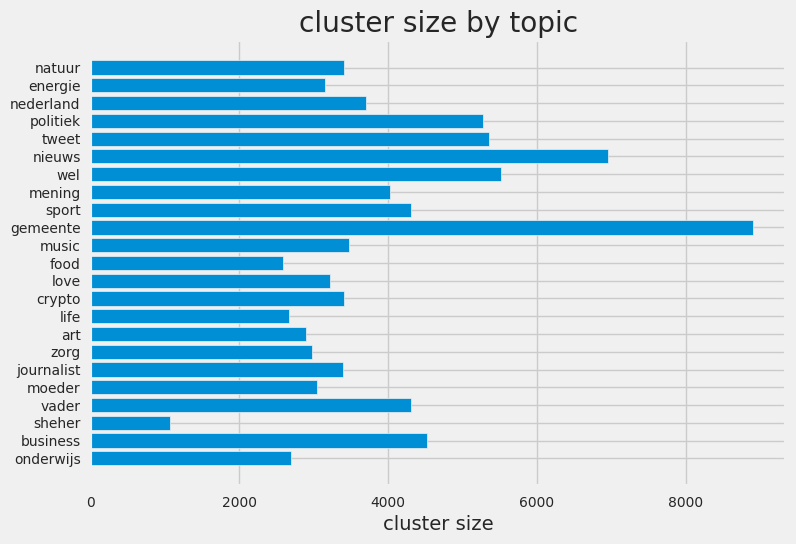

In [22]:
# Bar graph with named labels
cluster_size = list(freq_dict.values())
fig, ax = plt.subplots()


ax.barh(np.arange(len(name_list)), cluster_size, align='center')
ax.set_yticks(np.arange(len(name_list)), labels=name_list)
ax.invert_yaxis()
ax.set_xlabel('cluster size')
ax.set_title('cluster size by topic')

plt.show()